# **NEWS TOPIC CLASSIFIER USING BERT**

In [37]:
# TASK 1: BERT News Topic Classifier (AG News)

import os
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import gradio as gr

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# --- 1. Upload ZIP file from your PC ---
#from google.colab import files
#uploaded = files.upload()   # Choose your .zip file when prompted

# --- 2. Unzip the file ---
#import zipfile, os

#zip_filename = list(uploaded.keys())[0]  # Get uploaded file name
#extract_dir = "/content/drive/MyDrive/filder"       # Folder where you want to save files

#os.makedirs(extract_dir, exist_ok=True)

#with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
 #   zip_ref.extractall(extract_dir)

#print(f"Extracted {zip_filename} to {extract_dir}")

In [39]:
# 1) Load Dataset

print("\n___ Loading AG News dataset ___")
dataset = load_dataset("/content/drive/MyDrive/(( Internships Summer 2025 ))/Developers Hub/ag_news")
print(dataset)

# Quick peek
print("Sample example:", dataset["train"][0])


___ Loading AG News dataset ___
DatasetDict({
    train: Dataset({
        features: ['Class Index', 'Title', 'Description'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['Class Index', 'Title', 'Description'],
        num_rows: 7600
    })
})
Sample example: {'Class Index': 3, 'Title': 'Wall St. Bears Claw Back Into the Black (Reuters)', 'Description': "Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}


# **EDA**

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


/tmp/ipython-input-1412789753.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class Index", data=train_df, palette="viridis")


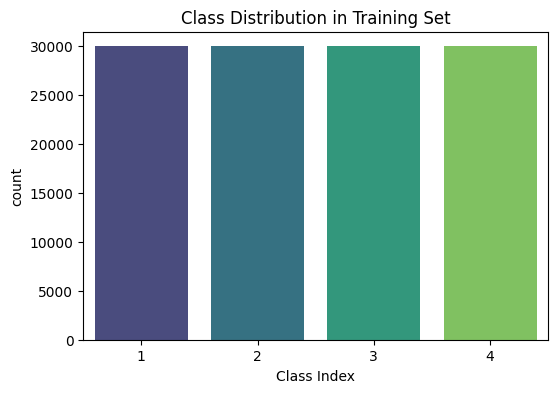

In [42]:
train_df = pd.DataFrame(dataset["train"])
print(train_df.head())

plt.figure(figsize=(6,4))
sns.countplot(x="Class Index", data=train_df, palette="viridis")
plt.title("Class Distribution in Training Set")
plt.show()

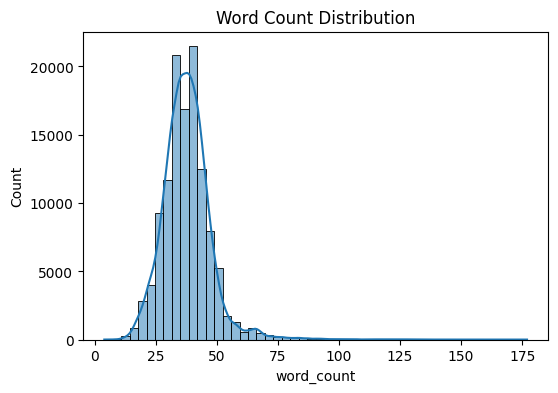

In [43]:
# Word Count Distribution

train_df["text"] = train_df["Title"].fillna("") + " " + train_df["Description"].fillna("")
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(train_df["word_count"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.show()

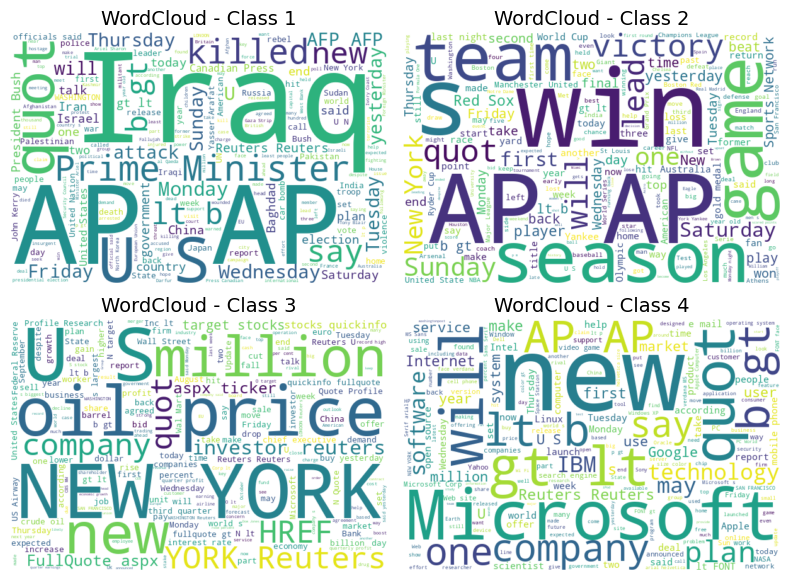

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Make WordClouds for each class
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for idx, label in enumerate(sorted(train_df["Class Index"].unique())):
    subset = " ".join(train_df[train_df["Class Index"] == label]["text"].tolist())
    wc = WordCloud(width=600, height=400, background_color="white").generate(subset)

    axes[idx].imshow(wc, interpolation="bilinear")
    axes[idx].axis("off")
    axes[idx].set_title(f"WordCloud - Class {label}", fontsize=14)

plt.tight_layout()
plt.show()

# **Preprocessing**

In [49]:
# Preprocess: combine Title + Description, remap labels

def preprocess_examples(examples):
    # Combine Title and Description
    text = []
    for t, d in zip(examples["Title"], examples["Description"]):
        combined = (t or "") + " " + (d or "")
        text.append(combined.strip())
    return {"text": text, "label": [c - 1 for c in examples["Class Index"]]}  # shift labels 1→0

dataset = dataset.map(preprocess_examples, batched=True)
dataset = dataset.remove_columns(["Title", "Description", "Class Index"])

print("Processed sample:", dataset["train"][0])

Processed sample: {'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


# **Tokenizer**

In [30]:
# 3) Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
max_length = 64

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_length)

encoded_dataset = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
train_dataset = encoded_dataset["train"].shuffle(seed=42).select(range(5000))   # reduce for speed
test_dataset = encoded_dataset["test"].shuffle(seed=42).select(range(1000))      # reduce for speed

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

# **BERT MODEL**

In [31]:
# Load Model

num_labels = 4
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# 5) Metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [33]:
# 6) Training

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=20,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

print("\n___ Starting Training ___")
trainer.train()
print("\n___ Training Completed ___")


___ Starting Training ___


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.274800,0.337448,0.911000,0.915075,0.912424,0.911009



___ Training Completed ___


In [34]:
SAVE_DIR = "/content/drive/MyDrive/(( Internships Summer 2025 ))/Developers Hub"
os.makedirs(SAVE_DIR, exist_ok=True)

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

# Save label mapping
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v: k for k, v in id2label.items()}

import json
with open(os.path.join(SAVE_DIR, "labels.json"), "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f)

print(f"\nSaved model, tokenizer, and labels to {SAVE_DIR}")


Saved model, tokenizer, and labels to /content/drive/MyDrive/(( Internships Summer 2025 ))/Developers Hub


In [35]:
# 8) Quick Evaluation

metrics = trainer.evaluate(test_dataset)
print("Evaluation:", metrics)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation: {'eval_loss': 0.33744823932647705, 'eval_accuracy': 0.911, 'eval_precision': 0.9150746428386306, 'eval_recall': 0.9124244924950958, 'eval_f1': 0.9110088398681022, 'eval_runtime': 119.5695, 'eval_samples_per_second': 8.363, 'eval_steps_per_second': 1.045, 'epoch': 1.0}


In [51]:
# Classification Report

y_true = test_dataset["label"]
preds = trainer.predict(test_dataset).predictions
y_pred = np.argmax(preds, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(id2label.values())))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report:
              precision    recall  f1-score   support

       World       0.97      0.85      0.91       266
      Sports       0.96      0.99      0.97       246
    Business       0.91      0.85      0.88       246
    Sci/Tech       0.82      0.95      0.88       242

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



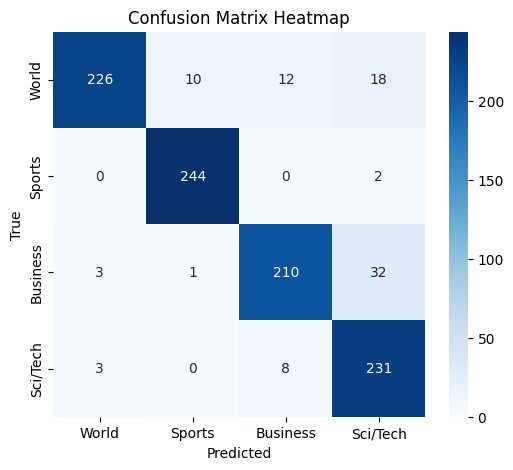

In [52]:
# Confusion Matrix Heatmap

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [36]:
# 9) Gradio Deployment

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    return {id2label[i]: float(preds[i]) for i in range(len(preds))}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=3, placeholder="Enter a news headline/description"),
    outputs=gr.Label(num_top_classes=4),
    title="DistilBERT - AG News Topic Classifier",
    description="Classifies news into 4 categories: World, Sports, Business, Sci/Tech"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a4353408c9f070ad35.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
